In [1]:
use_extracted_data = False

In [2]:
import glob
import os
import sys
import tempfile
import warnings

import cartopy.crs as ccrs
import numpy as np
import xarray as xr
from gplately import (
    pygplates,
    PlateReconstruction,
    PlotTopologies,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
)

from lib.animation import create_animation
from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)
from lib.erodep import (
    plot_combined,
    plot_combined_maps,
    plot_erosion,
    plot_erosion_maps,
    plot_erosion_rate,
    plot_erosion_rate_maps,
    plot_likelihood,
    plot_likelihood_maps,
)
from lib.misc import reconstruct_by_topologies

In [3]:
n_jobs = int(os.environ.get("N_JOBS", 8))
verbose = bool(int(os.environ.get("VERBOSE", 0)))
overwrite = bool(int(os.environ.get("OVERWRITE", 1)))
save_grids = bool(int(os.environ.get("SAVE_GRIDS", 1)))

times = range(171)
filename_template = r"image_{:0.0f}Ma.png"

## Input and output files

In [4]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = check_prepared_data("prepared_data")
input_filename = os.path.join(
    data_dir,
    "grid_data.csv",
)
deposits_filename = os.path.join(
    data_dir,
    "training_data_global.csv",
)

outputs_dir = "outputs"
erosion_grids_dir = os.path.join(outputs_dir, "erosion_grids")
erorate_dir = "erodep_maps"
outputs_dir = os.path.join("outputs", "global")
# Input
dist_parametric_filename = os.path.join(outputs_dir, "erodep_dist_parametric.joblib")
dist_kde_filename = os.path.join(outputs_dir, "erodep_dist_kde.joblib")
# Output
likelihood_parametric_dir = os.path.join(
    outputs_dir,
    "preservation_likelihood_grids_parametric",
)
likelihood_kde_dir = os.path.join(
    outputs_dir,
    "preservation_likelihood_grids_kde",
)
prospectivity_dir = os.path.join(
    outputs_dir,
    "PU",
    "probability_grids",
)

output_filename_erosion = os.path.join(
    outputs_dir,
    "erosion.mp4",
)
output_filename_rate = os.path.join(
    outputs_dir,
    "erosion_rate.mp4",
)
output_filename_parametric = os.path.join(
    outputs_dir,
    "likelihood_parametric.mp4",
)
output_filename_kde = os.path.join(
    outputs_dir,
    "likelihood_kde.mp4",
)
output_filename_combined_parametric = os.path.join(
    outputs_dir,
    "PU",
    "prospectivity_likelihood_parametric.mp4",
)
output_filename_combined_parametric_nodeps = os.path.join(
    os.path.dirname(output_filename_combined_parametric),
    os.path.basename(output_filename_combined_parametric).replace(".mp4", "_nodeps.mp4"),
)
output_filename_combined_kde = os.path.join(
    outputs_dir,
    "PU",
    "prospectivity_likelihood_kde.mp4",
)
output_filename_combined_kde_nodeps = os.path.join(
    os.path.dirname(output_filename_combined_kde),
    os.path.basename(output_filename_combined_kde).replace(".mp4", "_nodeps.mp4"),
)

### Plate model files

In [5]:
plate_model_dir = check_plate_model("plate_model")

topological_files = glob.glob(
    os.path.join(
        plate_model_dir,
        "*.gpml*",
    )
)
topological_files = [
    i for i in topological_files
    if "inactive" not in os.path.basename(i).lower()
]
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ImportWarning)
    topological_features = pygplates.FeatureCollection(
        [
            i for i in
            pygplates.FeaturesFunctionArgument(topological_files).get_features()
            if i.get_feature_type().to_qualified_string() != "gpml:TopologicalSlabBoundary"
        ]
    )
rotation_files = glob.glob(
    os.path.join(
        plate_model_dir,
        "*.rot",
    )
)
# coastlines_filename = os.path.join(
#     plate_model_dir,
#     "StaticGeometries",
#     "AgeGridInput",
#     "CombinedTerranes.gpml",
# )
coastlines_filename = [
    os.path.join(plate_model_dir, i)
    for i in (
        "Clennett_2020_Coastlines.gpml",
        "Clennett_2020_Terranes.gpml",
    )
]

reconstruction = PlateReconstruction(
    rotation_files,
    topological_features,
    static_polygons=coastlines_filename,
)
gplot = PlotTopologies(
    reconstruction,
    coastlines=coastlines_filename,
)

projection = ccrs.Mollweide()


### Erosion rate

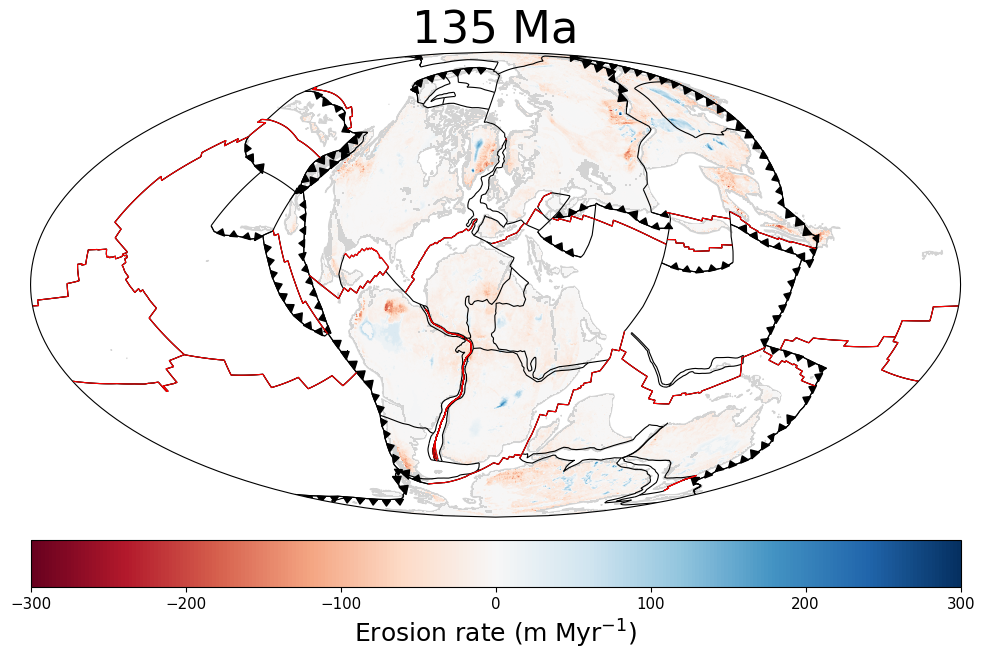

In [6]:
time = 135
_ = plot_erosion_rate(
    time=time,
    gplot=gplot,
    input_dir=erorate_dir,
    projection=projection,
    output_filename=None,
)

In [7]:
if overwrite or (not os.path.isfile(output_filename_rate)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_erosion_rate_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            input_dir=erorate_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=verbose,
            output_template=filename_template,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_rate,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

### Cumulative erosion

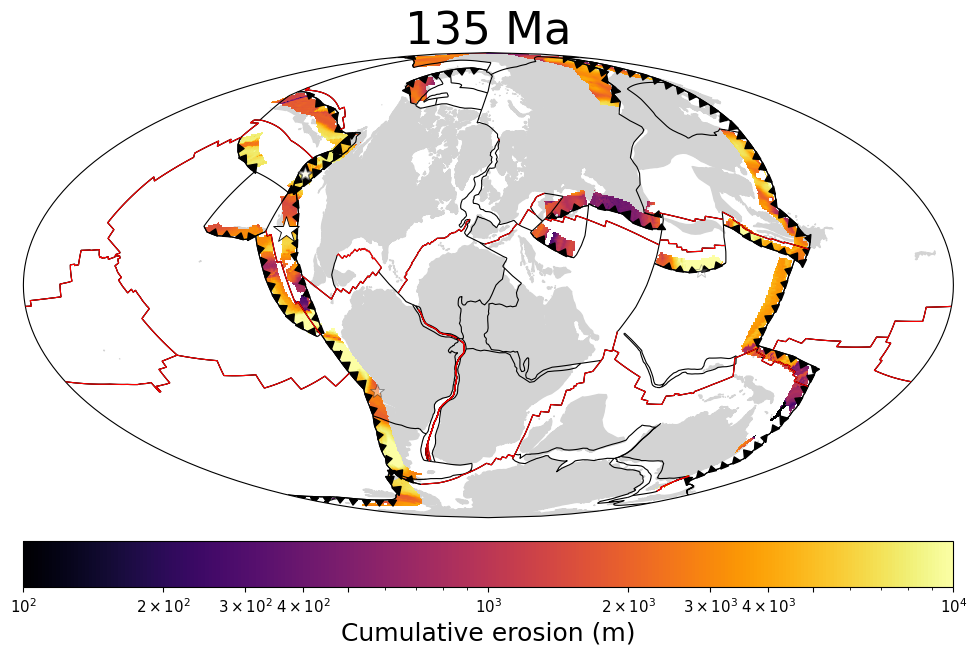

In [8]:
time = 135
_ = plot_erosion(
    time=time,
    gplot=gplot,
    input_dir=erosion_grids_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


In [9]:
if overwrite or (not os.path.isfile(output_filename_erosion)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_erosion_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            input_dir=erosion_grids_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits_filename,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_erosion,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

### Preservation likelihood (parametric)

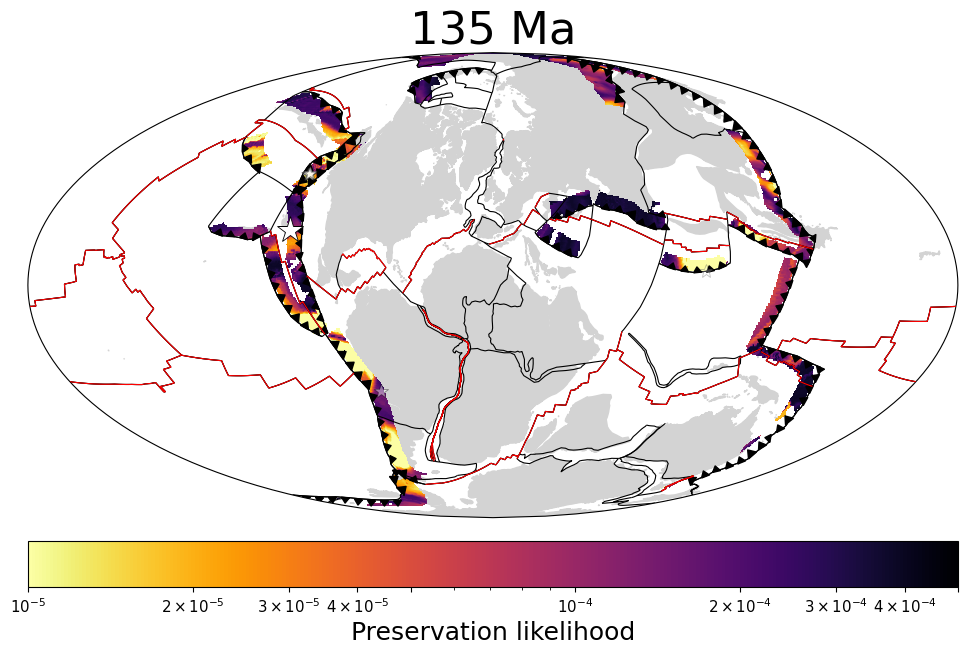

In [10]:
time = 135

_ = plot_likelihood(
    time=time,
    gplot=gplot,
    input_dir=likelihood_parametric_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


In [11]:
if overwrite or (not os.path.isfile(output_filename_parametric)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_likelihood_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            input_dir=likelihood_parametric_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits_filename,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_parametric,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

### Preservation likelihood (KDE)

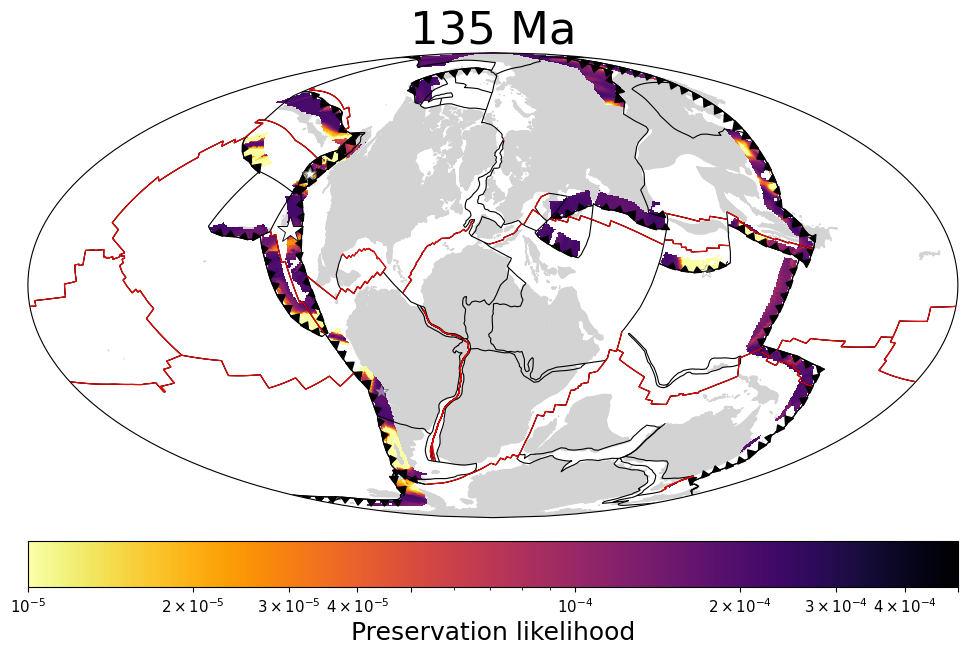

In [12]:
time = 135

_ = plot_likelihood(
    time=time,
    gplot=gplot,
    input_dir=likelihood_kde_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
)


In [13]:
if overwrite or (not os.path.isfile(output_filename_kde)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_likelihood_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            input_dir=likelihood_kde_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits_filename,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_kde,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

### Prospectivity $\times$ log(preservation likelihood) (parametric)

In [14]:
# Transform and scale likelihood
x = np.dstack(
    [
        np.array(
            xr.load_dataset(
                os.path.join(
                    likelihood_parametric_dir,
                    f"preservation_likelihood_grid_{t:0.0f}Ma.nc",
                )
            )["z"]
        )
        for t in times
    ]
)
x = x[~np.logical_or(np.isnan(x), x == 0.0)].reshape((-1, 1))

transformer = make_pipeline(
    FunctionTransformer(np.log, np.exp, check_inverse=False),
    MinMaxScaler(),
).fit(x)


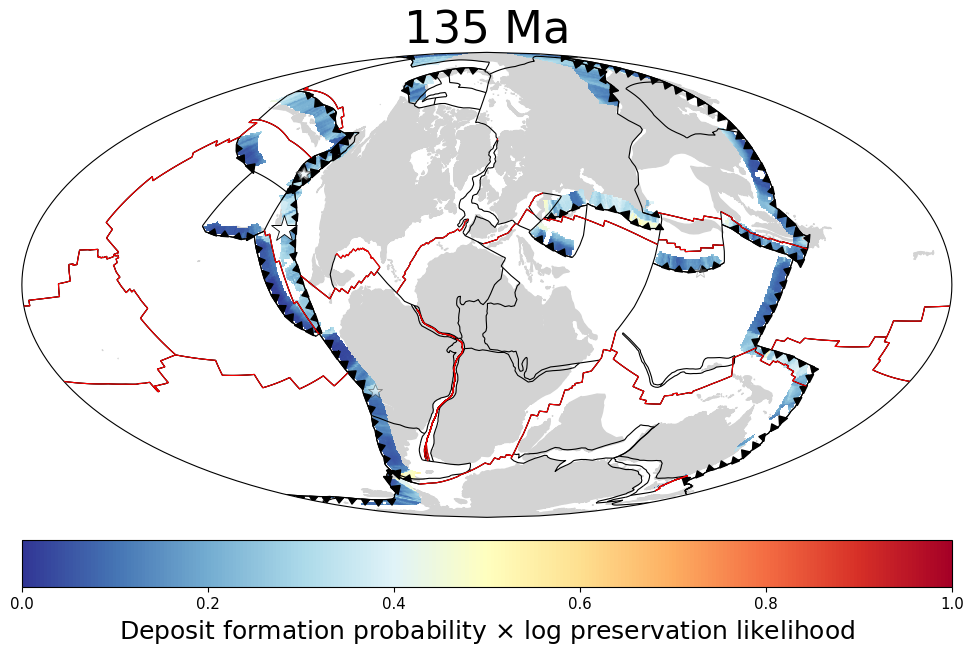

In [15]:
time = 135

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_parametric_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
    method="likelihood",
    transformer=transformer,
)


In [16]:
if overwrite or (not os.path.isfile(output_filename_combined_parametric)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_combined_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            prospectivity_dir=prospectivity_dir,
            preservation_dir=likelihood_parametric_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits_filename,
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_combined_parametric,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

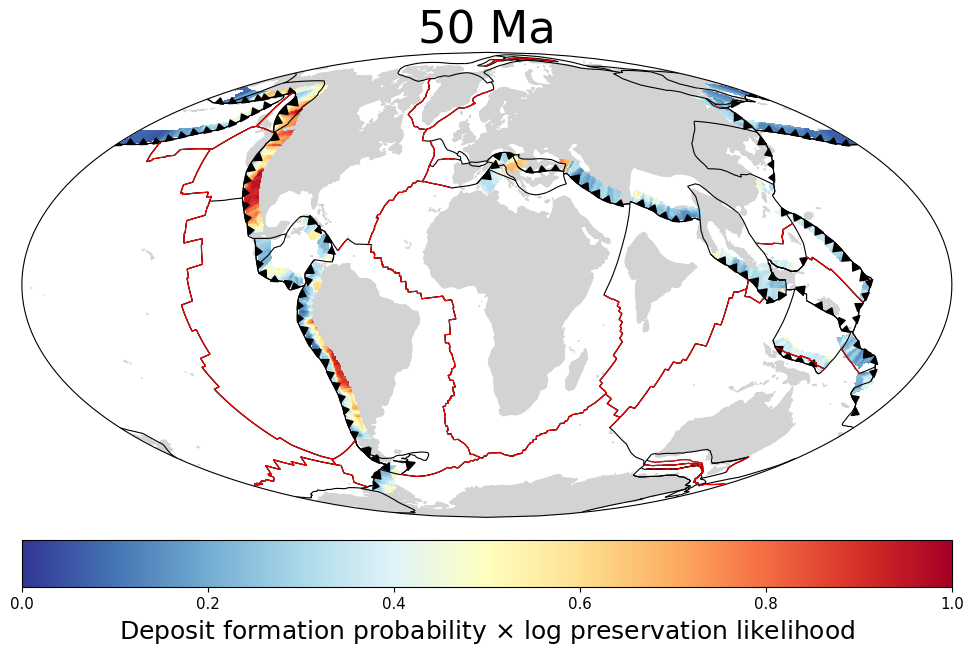

In [17]:
time = 50

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_parametric_dir,
    projection=projection,
    output_filename=None,
    deposits=None,
    method="likelihood",
    transformer=transformer,
)


In [18]:
if overwrite or (not os.path.isfile(output_filename_combined_parametric_nodeps)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_combined_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            prospectivity_dir=prospectivity_dir,
            preservation_dir=likelihood_parametric_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=None,
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_combined_parametric_nodeps,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

### Prospectivity $\times$ log(preservation likelihood) (KDE)

In [19]:
# Transform and scale likelihood
x = np.dstack(
    [
        np.array(
            xr.load_dataset(
                os.path.join(
                    likelihood_kde_dir,
                    f"preservation_likelihood_grid_{t:0.0f}Ma.nc",
                )
            )["z"]
        )
        for t in times
    ]
)
x = x[~np.logical_or(np.isnan(x), x == 0.0)].reshape((-1, 1))

transformer = make_pipeline(
    FunctionTransformer(np.log, np.exp, check_inverse=False),
    MinMaxScaler(),
).fit(x)


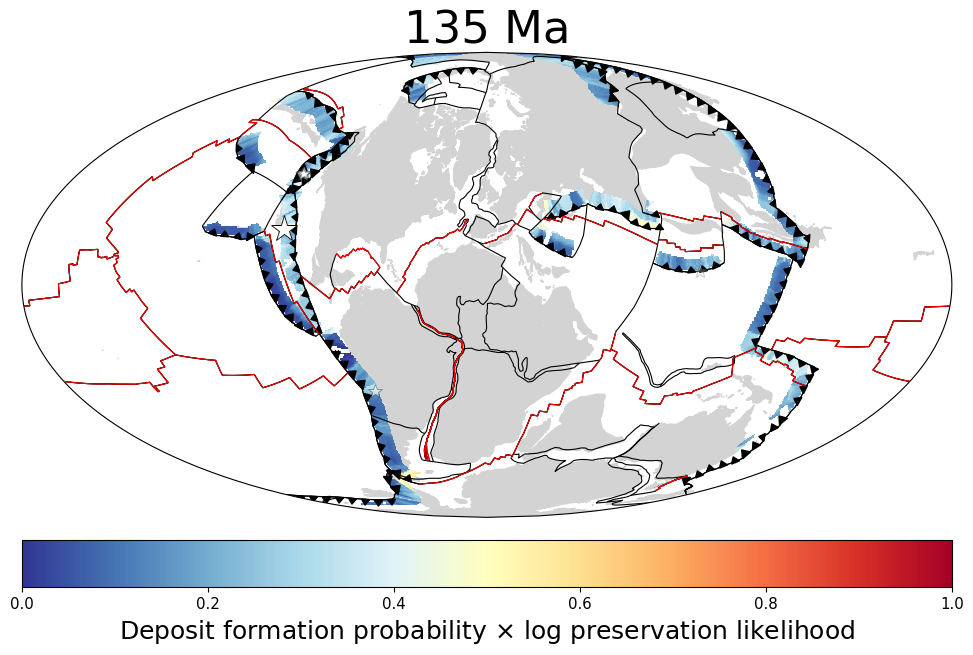

In [20]:
time = 135

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_kde_dir,
    projection=projection,
    output_filename=None,
    deposits=deposits_filename,
    method="likelihood",
    transformer=transformer,
)


In [21]:
if overwrite or (not os.path.isfile(output_filename_combined_kde)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_combined_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            prospectivity_dir=prospectivity_dir,
            preservation_dir=likelihood_kde_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=deposits_filename,
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_combined_kde,
            fps=5,
            logger=None,
            threads=n_jobs,
        )

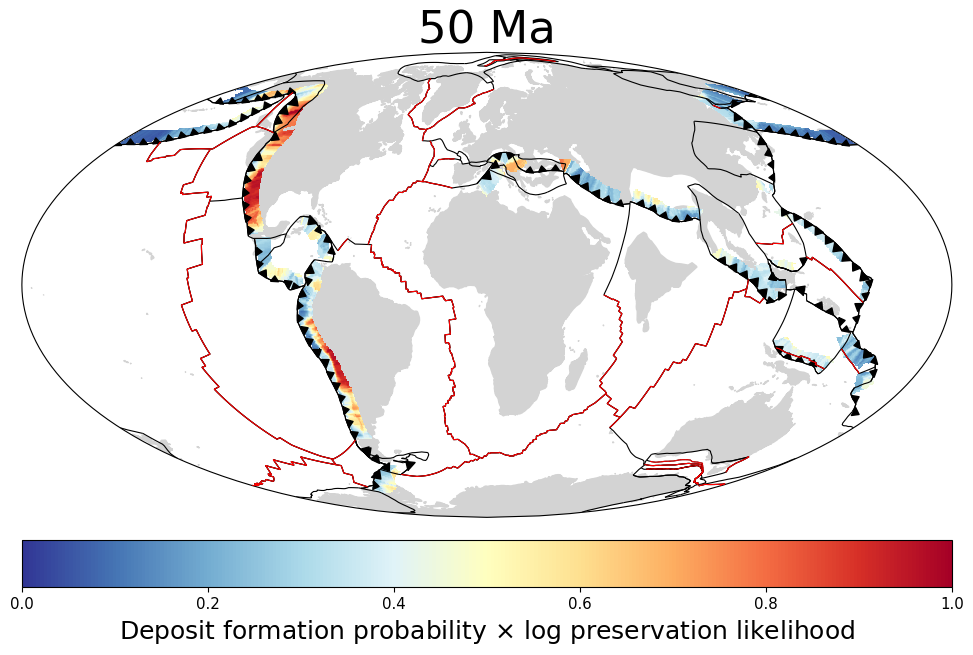

In [22]:
time = 50

_ = plot_combined(
    time=time,
    gplot=gplot,
    prospectivity_dir=prospectivity_dir,
    preservation_dir=likelihood_kde_dir,
    projection=projection,
    output_filename=None,
    deposits=None,
    method="likelihood",
    transformer=transformer,
)


In [23]:
if overwrite or (not os.path.isfile(output_filename_combined_kde_nodeps)):
    with tempfile.TemporaryDirectory() as tmpdir:
        tmp_topologies = os.path.join(tmpdir, "topologies.gpml")
        topological_features.write(tmp_topologies)

        plot_combined_maps(
            times=times,
            topology_filenames=tmp_topologies,
            rotation_filenames=rotation_files,
            coastline_filenames=coastlines_filename,
            prospectivity_dir=prospectivity_dir,
            preservation_dir=likelihood_kde_dir,
            output_dir=tmpdir,
            projection=projection,
            n_jobs=n_jobs,
            verbose=10 * int(verbose),
            output_template=filename_template,
            deposits=None,
            method="likelihood",
            transformer=transformer,
        )
        image_filenames = [
            os.path.join(
                tmpdir,
                filename_template.format(t),
            )
            for t in sorted(times, reverse=True)
        ]
        create_animation(
            image_filenames=image_filenames,
            output_filename=output_filename_combined_kde_nodeps,
            fps=5,
            logger=None,
            threads=n_jobs,
        )